# Data Preprocessing

In [1]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

import pandas as pd
import pandas.util.testing as tm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
#sns.set_context("poster")

C:\Users\duart\AppData\Local\conda\conda\envs\testEnv\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import sys


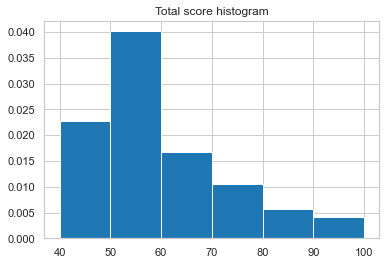

In [2]:
times = pd.read_csv("timesData.csv").sort_values(by = "total_score", ascending = False)

from matplotlib import pyplot

times["total_score"] = pd.to_numeric(times["total_score"], errors = "coerce")
bins = np.arange(40, 110, 10)
pyplot.hist(times["total_score"], density = True, bins = bins)
pyplot.title("Total score histogram")
pyplot.show()

From the histogram above, the data is skewed to the right. Therefore to run a regression analysis, the output variable would have to be logged.

However, since in this notebook we will only try to run simple binary classifications, we will not need to modify the y variables

In [3]:
%%writefile times_clean.py

import pandas as pd

def times_clean(x, data, year = None):
    
    # assert x is an int   
    assert type(x) == int, "Your top value is not in a valid format, please enter an integer"
    assert type(data) == pd.core.frame.DataFrame, "Data has to be in a pandas dataframe format"
    
    # make total_score numeric
    data["total_score"] = pd.to_numeric(data["total_score"], errors = "coerce")
    
    # drop NAs in total_score
    data.dropna(subset = ["total_score"], inplace = True)
    
    # make sure values in the total_score column are sorted
    data.sort_values(by = "total_score", ascending = False)
    
    # filter by only the selected year
    if year != None:
        data = data[data["year"] == year]
        
    # Convert all other columns to float type
    data["international"] = pd.to_numeric(data["international"], errors = "coerce")
    data["income"] = pd.to_numeric(data["income"], errors = "coerce") 
    data["female_male_ratio"] = pd.to_numeric(data["female_male_ratio"].apply(lambda d: str(d).split(" : ")[0]), errors = "coerce")
    data["international_students"] = pd.to_numeric(data["international_students"].apply(lambda d: str(d).split("%")[0]), errors = "coerce")
    data["num_students"] = pd.to_numeric(data["num_students"].apply(lambda d: str(d).replace(",", ".")), errors = "coerce")
    
    # find the nth_score
    scores = list(data["total_score"])
    score_x = scores[x]
    
    # code output variable
    data["top_" + str(x)] = data["total_score"].apply(lambda d: 1 if d >= score_x else 0) 
    
    return data

Overwriting times_clean.py


In [4]:
import times_clean as tc
times_clean = tc.times_clean(100, times)
times_treat = times_clean[["teaching", "international", "research", "citations", "income", "num_students", "international_students", "female_male_ratio", "top_" + str(100)]]
times_treat.dropna(inplace = True)

C:\Users\duart\AppData\Local\conda\conda\envs\testEnv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Feature Selection

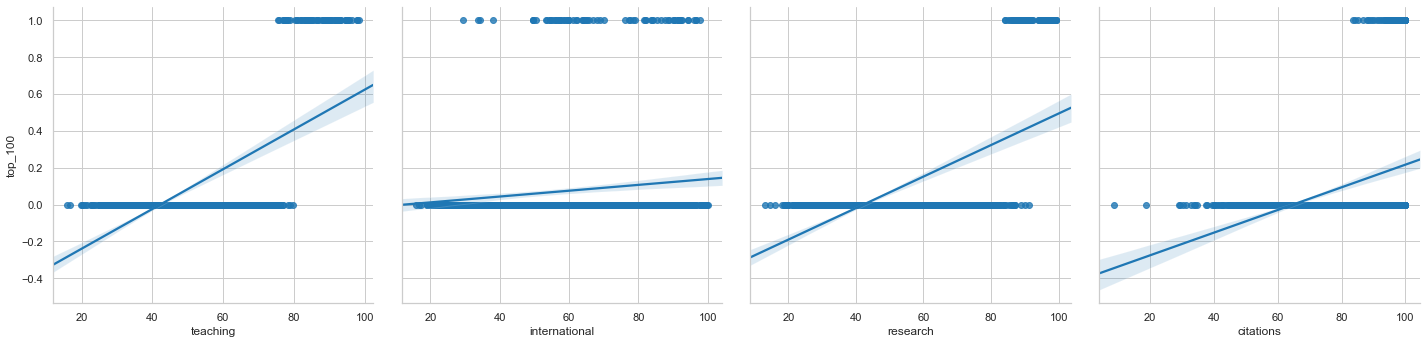

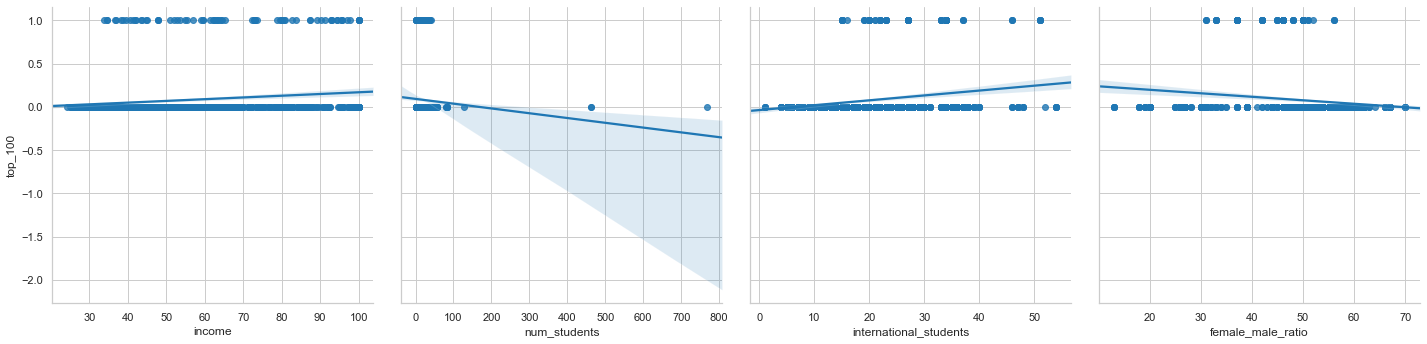

In [5]:
# Use pairplots to visualize the most important features

sns.pairplot(times_treat, x_vars = times_treat.columns[:-5], y_vars = times_treat.columns[-1:], kind = "reg", height = 5)
sns.pairplot(times_treat, x_vars = times_treat.columns[-5:-1], y_vars = times_treat.columns[-1:], kind = "reg", height = 5)

While the graphs above are not perfect visualizations (since were dealing with a binary outcome variable), they help us understand the relationship between the predictors and the outcome easily.

The two features with a strong relationship to the outcome variable are 'teaching', 'research' and 'citation'

All three have a positive and strong relationship to the outcome, especially teaching and research.

Number of students has a negative relationship, but it is weak

To visualize the relationship of different features to the y variable, we can use histograms plotting the two outcomes against a specific x variable

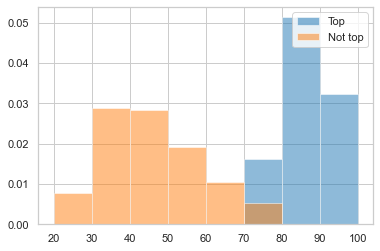

In [26]:
bins = np.arange(20, 110, 10)

import numpy as np

pyplot.hist(times_treat[times_treat['top_100']==1]['teaching'], bins, alpha=0.5, density=True, label='Top')
pyplot.hist(times_treat[times_treat['top_100']==0]['teaching'], bins, alpha=0.5, density=True, label='Not top')
pyplot.legend(loc='upper right')
pyplot.show()

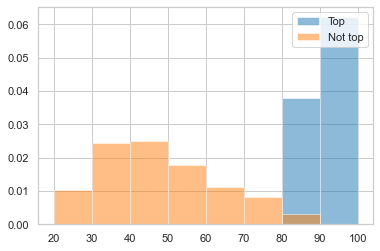

In [27]:
bins = np.arange(20, 110, 10)

import numpy as np

pyplot.hist(times_treat[times_treat['top_100']==1]['research'], bins, alpha=0.5, density=True, label='Top')
pyplot.hist(times_treat[times_treat['top_100']==0]['research'], bins, alpha=0.5, density=True, label='Not top')
pyplot.legend(loc='upper right')
pyplot.show()

From the two histograms above, we can see that teaching and research seems very strong features to predict the outcome (whether a university falls in the top 100 or not)

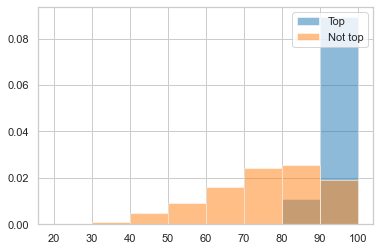

In [30]:
bins = np.arange(20, 110, 10)

import numpy as np

pyplot.hist(times_treat[times_treat['top_100']==1]['citations'], bins, alpha=0.5, density=True, label='Top')
pyplot.hist(times_treat[times_treat['top_100']==0]['citations'], bins, alpha=0.5, density=True, label='Not top')
pyplot.legend(loc='upper right')
pyplot.show()

Citations also seems a strong predictor for the outcome variable

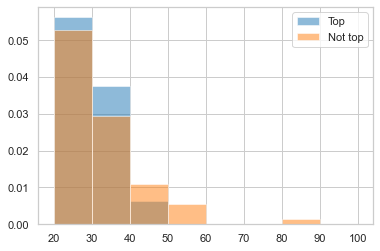

In [31]:
bins = np.arange(20, 110, 10)

import numpy as np

pyplot.hist(times_treat[times_treat['top_100']==1]['num_students'], bins, alpha=0.5, density=True, label='Top')
pyplot.hist(times_treat[times_treat['top_100']==0]['num_students'], bins, alpha=0.5, density=True, label='Not top')
pyplot.legend(loc='upper right')
pyplot.show()

Number of students may give an indication, but not a strong one

In [8]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 
from sklearn.ensemble import ExtraTreesClassifier

In [9]:
# Times top-100 analysis

times_cols = times_treat.columns
array_100 = times_treat.values

times_x100 = array_100[:,0:8]
times_y100 = array_100[:,8]

# Run Logistic Regression

model = LogisticRegression(solver='liblinear')
rfe = RFE(model, 3) 
rec = rfe.fit(times_x100, times_y100)

# Automate column outputs for RFE
 
rec_cols = rec.ranking_.argsort()[:3]

print('\033[1m' + 'Recursive Feature Elimination' '\033[0m')
print(f'Number of features {rec.n_features_:d}')
print(f'Selected features {rec.support_}')
print(f'Ranking of features {rec.ranking_}')
print(f"Top features are {times_cols[rec_cols[0]]}, {times_cols[rec_cols[1]]}, and {times_cols[rec_cols[2]]}")
print()

# Run univariate analysis

test = SelectKBest(score_func=chi2, k=3)
uni = test.fit(times_x100, times_y100)

print('\033[1m' + 'Univariate Analysis' '\033[0m')
print(uni.scores_)

uni_cols = uni.scores_.argsort()[-3:]
print("The top features are: " + times_cols[uni_cols[0]] + ", " + times_cols[uni_cols[1]] + ", " + times_cols[uni_cols[2]])
print()

features=uni.transform(times_x100)
features[0:9,:]

# Model with top 50 estimators

print('\033[1m' + 'Tree Model: Top Nodes' '\033[0m')

model_100 = ExtraTreesClassifier(n_estimators=100)
model_100.fit(times_x100, times_y100)

indices_100 = model_100.feature_importances_.argsort()[-3:]
print("The top 3 features are: " + times_cols[indices_100[0]] + ", " + times_cols[indices_100[1]] + ", " + times_cols[indices_100[2]])
print(model_100.feature_importances_)

scores = {}
scores["Features"] = times_treat.columns[:8]
scores["RFE"] = rec.ranking_
scores["Univariate"] = uni.scores_
scores["Tree Model"] = model_100.feature_importances_

pd.DataFrame.from_dict(scores)

Recursive Feature Elimination
Number of features 3
Selected features [False False  True False False  True False  True]
Ranking of features [2 6 1 4 3 1 5 1]
Top features are research, num_students, and female_male_ratio

Univariate Analysis
[2307.72671449   99.61315102 2667.54584982  368.23598221  263.85308593
  217.17865043  252.82966895   47.06303068]
The top features are: citations, teaching, research

Tree Model: Top Nodes
The top 3 features are: citations, teaching, research
[0.30388684 0.03250449 0.38396772 0.10072893 0.03016285 0.0459815
 0.05213634 0.05063133]


,Features,RFE,Univariate,Tree Model
0,teaching,2,2307.726714,0.303887
1,international,6,99.613151,0.032504
2,research,1,2667.545850,0.383968
3,citations,4,368.235982,0.100729
4,income,3,263.853086,0.030163
5,num_students,1,217.178650,0.045981
6,international_students,5,252.829669,0.052136
7,female_male_ratio,1,47.063031,0.050631


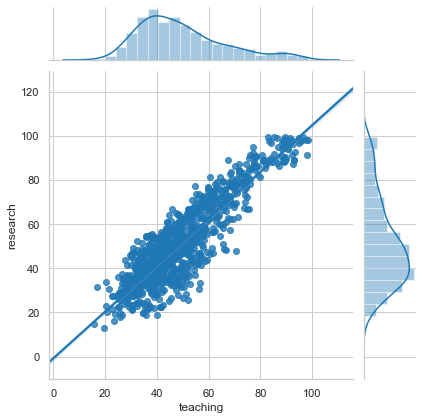

In [10]:
sns.jointplot(x="teaching",y="research",data=times_treat, kind="reg")

# Models

In [11]:
# Create the DataFrames for plotting
resall=pd.DataFrame()
res_log=pd.DataFrame()
res_cart=pd.DataFrame()
res_svm=pd.DataFrame()
res_nb=pd.DataFrame()

## Logistic Regression

In [12]:
X_log = times_treat[["research", "num_students", "female_male_ratio"]].values
y_log = times_treat["top_100"].values

In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [14]:
# Logistic Regression

kfold=KFold(n_splits=5, shuffle = True)

model=LogisticRegression(solver="liblinear")

results=cross_val_score(model, X_log, y_log, cv=kfold)

print(f'Logistic Regression - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

res_log["Res"]=results
res_log["Type"]="log"

Logistic Regression - Accuracy 96.855% std 0.876109


## CART

In [15]:
X = times_treat[["research", "teaching", "citations"]].values
y = times_treat["top_100"].values

In [16]:
from sklearn.tree import DecisionTreeClassifier

kfold=KFold(n_splits=5, random_state=7, shuffle = True)

model=DecisionTreeClassifier(class_weight="balanced")

results=cross_val_score(model, X, y, cv=kfold)

print(f'Decision Tree - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

res_cart["Res"]=results
res_cart["Type"]="CART"

Decision Tree - Accuracy 99.371% std 0.392979


## SVM

In [17]:
from sklearn.svm import SVC

kfold=KFold(n_splits=5, random_state=7, shuffle = True)

model=SVC(gamma="scale")

results=cross_val_score(model, X, y, cv=kfold)

print(f'Support Vector Machines - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3}')

res_svm["Res"]=results
res_svm["Type"]="SVM"

Support Vector Machines - Accuracy 99.161% std 0.5362038745856883


## Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB

kfold=KFold(n_splits=5, random_state=7, shuffle = True)

model=GaussianNB()

results=cross_val_score(model, X, y, cv=kfold)

print(f'Naive Bayes - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

res_nb["Res"]=results
res_nb["Type"]="Naive Bayes"

Naive Bayes - Accuracy 98.532% std 0.515694


# Algorithm Comparison

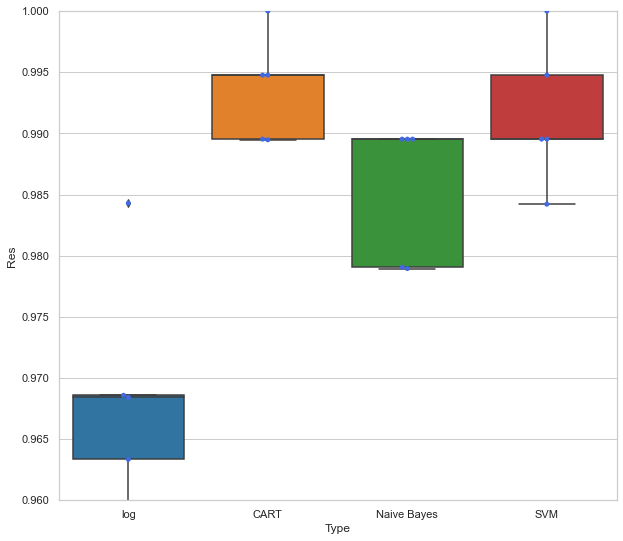

In [25]:
resall=pd.concat([res_log,res_cart,res_nb,res_svm], ignore_index=True)

plt.figure(figsize=(10,9))

sns.boxplot(data=resall, x="Type", y="Res")

plt.ylim(0.96, 1.00)

sns.swarmplot(data=resall, x="Type", y="Res", color="royalblue")